In [21]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss

In [22]:
import sys
from pathlib import Path

# Get current notebook directory
current_dir = Path.cwd()

# Move up until we find 'src'
for parent in current_dir.parents:
    if parent.name == "src":
        sys.path.append(str(parent))
        break
else:
    raise RuntimeError("Could not find 'src' directory")

from common import monk_utils as utils
from common.monk_utils import MonkDataset

In [23]:
RANDOM_STATE = 42

In [24]:


def run_monk_experiment(train_dataset, test_dataset, id_dataset):
    print(f"\n{'='*20} Processing MONK {id_dataset} (Linear SGD) {'='*20}")
    
    # 1. Load Data
    X_train_raw, y_train = utils.load_monk_dataset(train_dataset)
    X_test_raw, y_test = utils.load_monk_dataset(test_dataset)
    
    # 2. One-Hot Encoding
    # Linear models strictly need One-Hot for categorical data to assign weights to each value
    encoder = utils.MonkEncoder()
    X_train = encoder.fit_transform(X_train_raw)
    X_test = encoder.transform(X_test_raw)
    
    print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
    
    # 3. Model Selection (Grid Search)
    # We tune the Learning Rate (eta0) and Regularization (alpha)
    kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    
    # Hyperparameters
    etas = [0.001, 0.01, 0.1]
    alphas = [0.0001, 0.001, 0.01, 0.1] # Regularization strength
    
    best_score = -np.inf
    best_params = {}
    
    print("Starting Grid Search...")
    
    for eta in etas:
        for alpha in alphas:
            fold_accs = []
            
            for train_idx, val_idx in kf.split(X_train):
                X_fold_tr, X_fold_val = X_train[train_idx], X_train[val_idx]
                y_fold_tr, y_fold_val = y_train[train_idx], y_train[val_idx]
                
                # SGDClassifier with 'log_loss' is essentially Logistic Regression trained via SGD
                # This simulates a "Single Neuron" with Sigmoid activation
                model = SGDClassifier(loss='log_loss', learning_rate='constant', 
                                      eta0=eta, alpha=alpha, random_state=RANDOM_STATE,
                                      max_iter=1000, tol=1e-3)
                model.fit(X_fold_tr, y_fold_tr)
                
                preds = model.predict(X_fold_val)
                fold_accs.append(utils.calc_accuracy(y_fold_val, preds))
            
            avg_acc = np.mean(fold_accs)
            if avg_acc > best_score:
                best_score = avg_acc
                best_params = {'eta0': eta, 'alpha': alpha}
                
    print(f"Best Params: {best_params} (CV Acc: {best_score:.2%})")
    
    # 4. Learning Curves (MSE & Accuracy vs Epochs)
    # Since scikit-learn's fit() does not return history, we must manually loop over epochs
    # using partial_fit() to generate the plots required by the professor.
    
    epochs = 200
    # Initialize model with best params
    model = SGDClassifier(loss='log_loss', learning_rate='constant', 
                          eta0=best_params['eta0'], alpha=best_params['alpha'], 
                          random_state=RANDOM_STATE)
    
    # Arrays to store history
    train_mses, test_mses = [], []
    train_accs, test_accs = [], []
    epoch_list = range(1, epochs + 1)
    
    # Manual Training Loop
    classes = np.unique(y_train)
    
    for _ in epoch_list:
        # Shuffle training data each epoch (SGD requirement)
        p = np.random.permutation(len(X_train))
        X_tr_shuffled, y_tr_shuffled = X_train[p], y_train[p]
        
        # Train one epoch
        model.partial_fit(X_tr_shuffled, y_tr_shuffled, classes=classes)
        
        # Evaluate
        tr_pred = model.predict(X_train)
        ts_pred = model.predict(X_test)
        
        train_mses.append(utils.calc_mse(y_train, tr_pred))
        test_mses.append(utils.calc_mse(y_test, ts_pred))
        train_accs.append(utils.calc_accuracy(y_train, tr_pred))
        test_accs.append(utils.calc_accuracy(y_test, ts_pred))

    # 5. Plotting
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # MSE Plot
    ax1.plot(epoch_list, train_mses, label='Train MSE', color='blue')
    ax1.plot(epoch_list, test_mses, label='Test MSE', color='red', linestyle='--')
    ax1.set_title(f'MONK {id_dataset}: MSE vs Epochs (Linear)')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('MSE')
    ax1.legend()
    ax1.grid(True)
    
    # Accuracy Plot
    ax2.plot(epoch_list, train_accs, label='Train Acc', color='blue')
    ax2.plot(epoch_list, test_accs, label='Test Acc', color='red', linestyle='--')
    ax2.set_title(f'MONK {id_dataset}: Accuracy vs Epochs (Linear)')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.show()
    
    # 6. Final Report
    print(f"FINAL REPORT for MONK {id_dataset} (Linear)")
    print(f"MSE (Train/Test):      {train_mses[-1]:.4f} / {test_mses[-1]:.4f}")
    print(f"Accuracy (Train/Test): {train_accs[-1]:.2%} / {test_accs[-1]:.2%}")


==================== Processing MONK 1 (Linear SGD) ====================
Train shape: (124, 17), Test shape: (432, 17)
Starting Grid Search...
Best Params: {'eta0': 0.1, 'alpha': 0.01} (CV Acc: 74.17%)


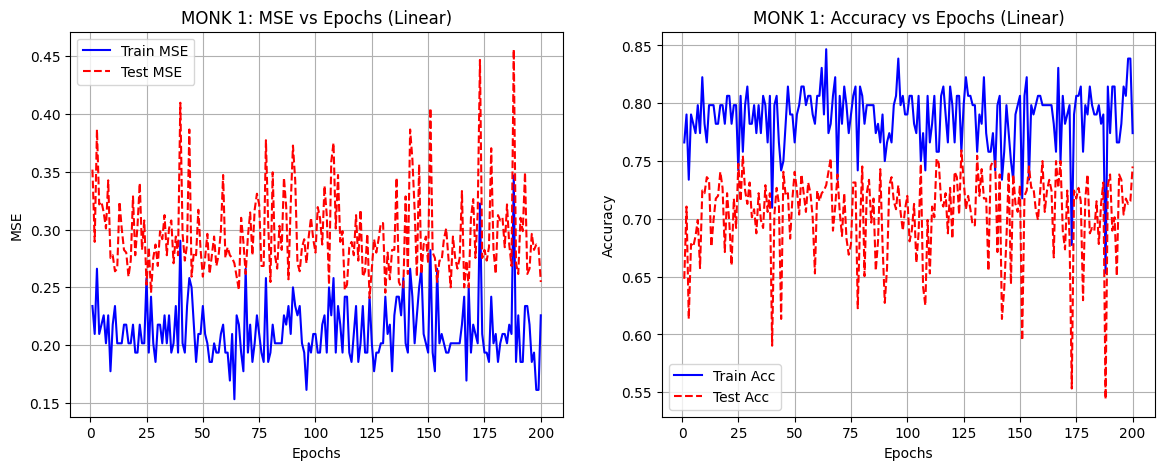

FINAL REPORT for MONK 1 (Linear)
MSE (Train/Test):      0.2258 / 0.2546
Accuracy (Train/Test): 77.42% / 74.54%

==================== Processing MONK 2 (Linear SGD) ====================
Train shape: (169, 17), Test shape: (432, 17)
Starting Grid Search...
Best Params: {'eta0': 0.001, 'alpha': 0.0001} (CV Acc: 62.10%)


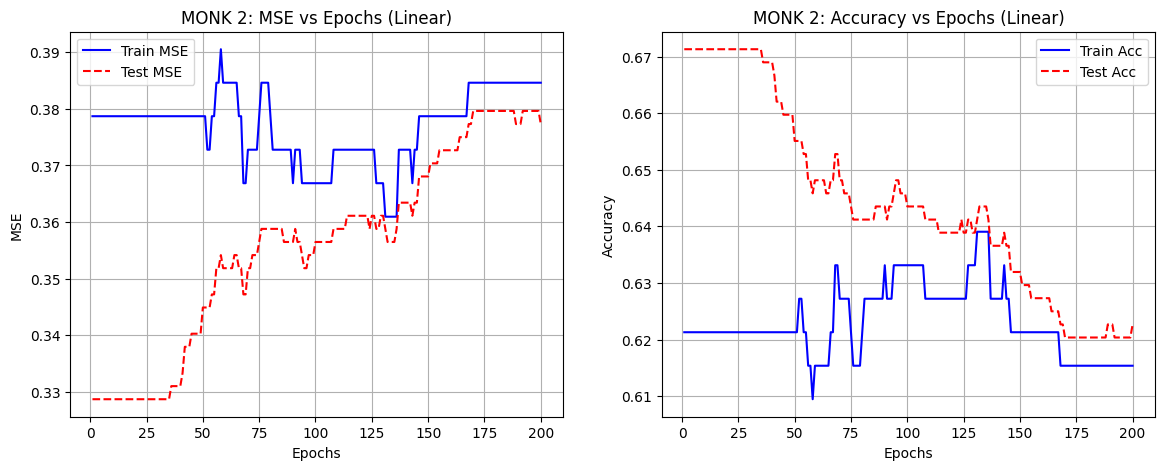

FINAL REPORT for MONK 2 (Linear)
MSE (Train/Test):      0.3846 / 0.3773
Accuracy (Train/Test): 61.54% / 62.27%

==================== Processing MONK 3 (Linear SGD) ====================
Train shape: (122, 17), Test shape: (432, 17)
Starting Grid Search...
Best Params: {'eta0': 0.01, 'alpha': 0.0001} (CV Acc: 91.80%)


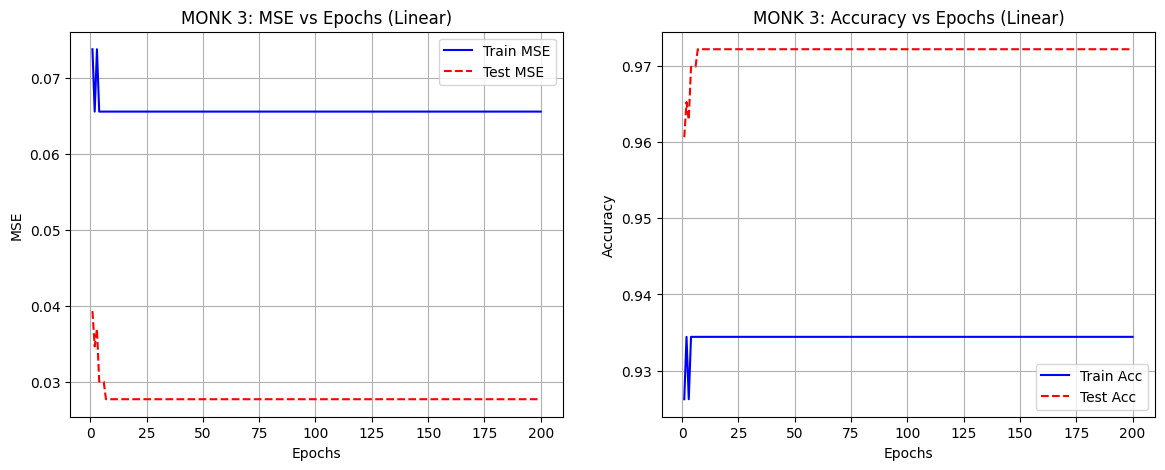

FINAL REPORT for MONK 3 (Linear)
MSE (Train/Test):      0.0656 / 0.0278
Accuracy (Train/Test): 93.44% / 97.22%


In [25]:
run_monk_experiment(train_dataset=MonkDataset.MONK1_TRAIN, test_dataset=MonkDataset.MONK1_TEST, id_dataset=1)
run_monk_experiment(train_dataset=MonkDataset.MONK2_TRAIN, test_dataset=MonkDataset.MONK2_TEST, id_dataset=2)
run_monk_experiment(train_dataset=MonkDataset.MONK3_TRAIN, test_dataset=MonkDataset.MONK3_TEST, id_dataset=3)